In [ ]:
## ELECTRIC VEHICLE BATTERY FAULT DIAGNOSIS

In [1]:
!pip install openpyxl

In [2]:
import pandas as pd

### SIMPLE CLASSIFICATION 

In [3]:
# Load the dataset
data = pd.read_excel('Simple.xlsx', engine='openpyxl')

In [4]:
data.head()

,SOC,Temperature,Voltage,Label
0,100.000000,298.150000,4.013998,0
1,99.166667,298.864522,3.914532,0
2,98.333333,299.693479,3.885572,0
3,97.500000,300.538842,3.875307,0
4,96.666667,301.380667,3.868728,0


In [5]:
data.shape

(728, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SOC          728 non-null    float64
 1   Temperature  728 non-null    float64
 2   Voltage      728 non-null    float64
 3   Label        728 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 22.9 KB


In [7]:
data.isna().sum()/len(data) * 100

SOC            0.0
Temperature    0.0
Voltage        0.0
Label          0.0
dtype: float64

## CONNECTING TO MYSQL

In [8]:
! pip install sqlalchemy
! pip install pymysql

In [9]:
from sqlalchemy import create_engine

In [10]:
# Database credentials
config = {
    'user': 'root',
    'password': 'Whiplash%4077',
    'host': 'localhost',
    'port': 3306,
    'database': 'EV'
}

In [11]:
engine = create_engine(f"mysql+pymysql://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}")

In [12]:
data.to_sql('analysis', con=engine, index=False, if_exists='replace')

728

#### QUERIES FROM SQL

In [13]:
Avg_SOC = pd.read_sql_query(''' SELECT round(AVG(SOC),2) as Avg_Soc FROM analysis ; ''', engine) 
Avg_SOC

,Avg_Soc
0,43.5


In [14]:
Min_Max_Vlt = pd.read_sql_query('''SELECT round(MIN(Voltage),2) as Min_vltg, round(MAX(Voltage),2) as max_vltg FROM analysis ; ''', engine)
Min_Max_Vlt

,Min_vltg,max_vltg
0,2.64,4.02


In [15]:
Label_counts = pd.read_sql_query(''' SELECT Label, COUNT(*) as counts
FROM analysis
GROUP BY Label;''', engine)
Label_counts

,Label,counts
0,0,364
1,1,364


In [16]:
Label_wise_avg_soc =pd.read_sql_query(''' SELECT Label, round(AVG(SOC),2) as Average_SOC
FROM analysis
GROUP BY Label;''', engine)
Label_wise_avg_soc 

,Label,Average_SOC
0,0,53.49
1,1,33.51


In [17]:
Label_wise_avg_vltg = pd.read_sql_query(''' SELECT Label, round(AVG(Voltage),2) as Average_Vltg
FROM analysis
GROUP BY Label;''', engine)
Label_wise_avg_vltg

,Label,Average_Vltg
0,0,3.48
1,1,3.21


## EXPLORATORY DATA ANALYSIS

In [18]:
import matplotlib.pyplot as plt

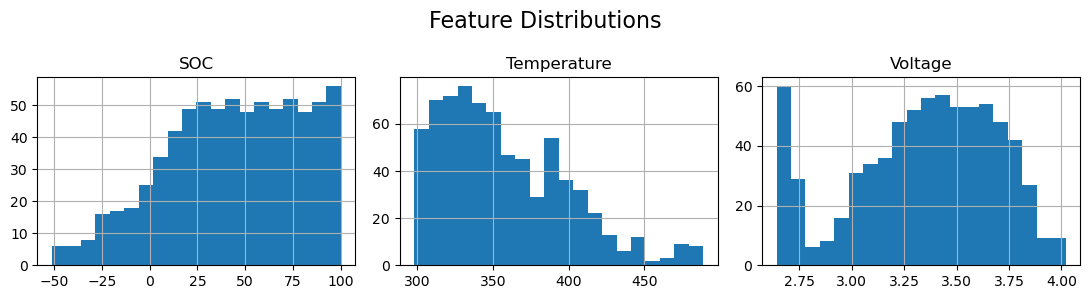

In [19]:
# Create subplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(11, 3))  # 1 row, 3 columns

# Plot each feature in its own subplot
data['SOC'].hist(bins=20, ax=axes[0])
axes[0].set_title('SOC')

data['Temperature'].hist(bins=20, ax=axes[1])
axes[1].set_title('Temperature')

data['Voltage'].hist(bins=20, ax=axes[2])
axes[2].set_title('Voltage')

# Set a common title
fig.suptitle('Feature Distributions', fontsize=16)

# Show the plots
plt.tight_layout()
plt.show()

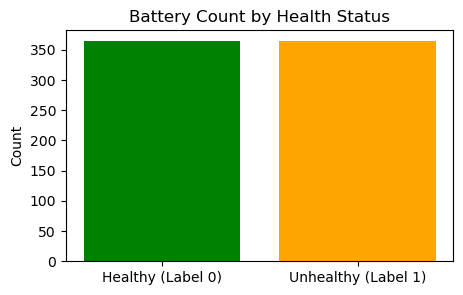

In [20]:
# Extract the data from the dataframe
labels = ['Healthy (Label 0)', 'Unhealthy (Label 1)']
counts = Label_counts['counts']

# Create a bar plot
plt.figure(figsize=(5, 3))
plt.bar(labels, counts, color=['green', 'orange'])
plt.title('Battery Count by Health Status')
plt.ylabel('Count')
plt.show()

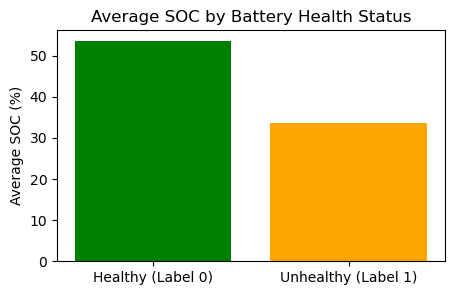

In [21]:
# Extract the data from the dataframe
labels = ['Healthy (Label 0)', 'Unhealthy (Label 1)']
avg_soc = Label_wise_avg_soc['Average_SOC']

# Create a bar plot
plt.figure(figsize=(5, 3))
plt.bar(labels, avg_soc, color=['green', 'orange'])
plt.title('Average SOC by Battery Health Status')
plt.ylabel('Average SOC (%)')
plt.show()

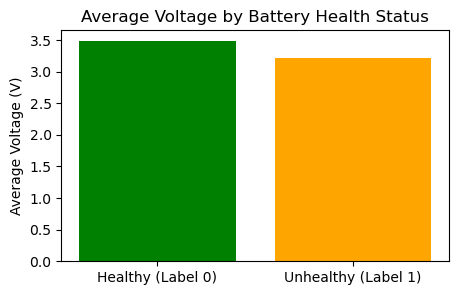

In [22]:
# Extract the data from the dataframe
labels = ['Healthy (Label 0)', 'Unhealthy (Label 1)']
avg_voltage = Label_wise_avg_vltg['Average_Vltg']

# Create a bar plot
plt.figure(figsize=(5, 3))
plt.bar(labels, avg_voltage, color=['green', 'orange'])
plt.title('Average Voltage by Battery Health Status')
plt.ylabel('Average Voltage (V)')
plt.show()

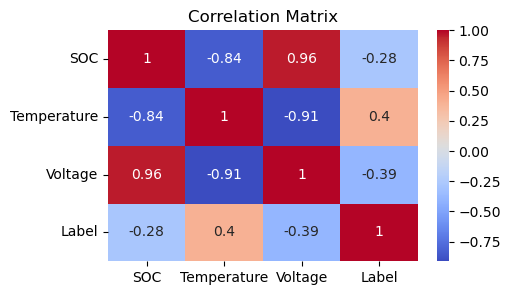

In [23]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

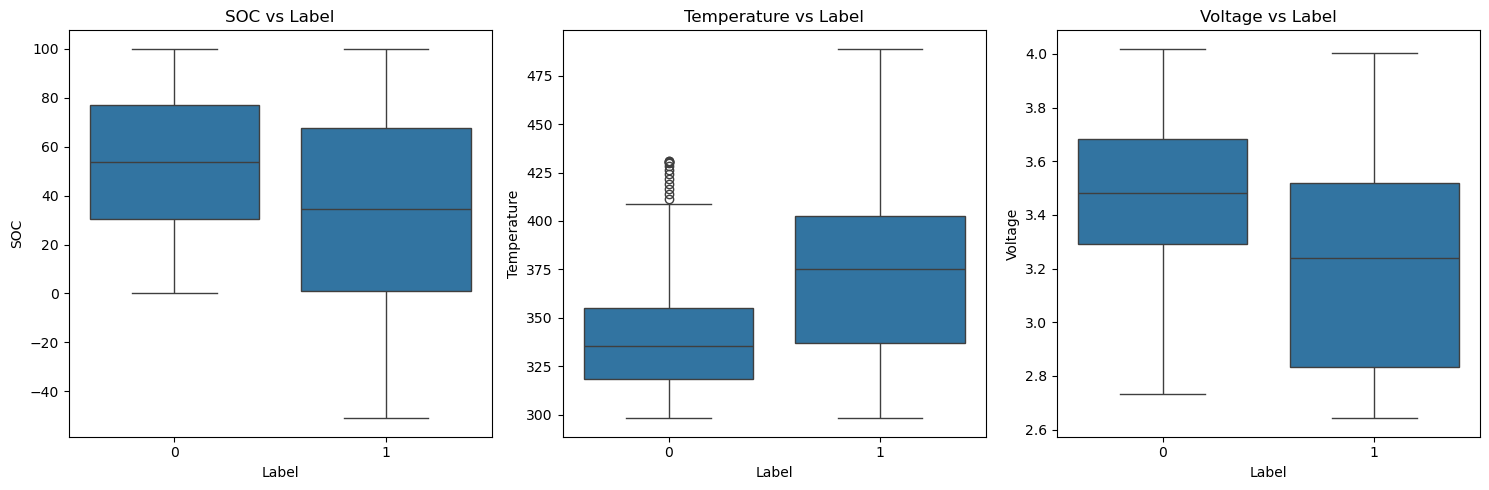

In [24]:
# Boxplots for SOC, Temperature, and Voltage based on battery health (Label)
plt.figure(figsize=(15, 5))

# SOC vs Label
plt.subplot(1, 3, 1)
sns.boxplot(x='Label', y='SOC', data=data)
plt.title('SOC vs Label')

# Temperature vs Label
plt.subplot(1, 3, 2)
sns.boxplot(x='Label', y='Temperature', data=data)
plt.title('Temperature vs Label')

# Voltage vs Label
plt.subplot(1, 3, 3)
sns.boxplot(x='Label', y='Voltage', data=data)
plt.title('Voltage vs Label')

plt.tight_layout()
plt.show()

## FEATURE ENGINEERING 

In [25]:
# Categorize SOC
bins_soc = [-float('inf'), 20, 80, float('inf')]
labels_soc = ['Low', 'Medium', 'High']
data['SOC_Category'] = pd.cut(data['SOC'], bins=bins_soc, labels=labels_soc)

# Categorize Temperature
bins_temp = [-float('inf'), 350, 400, float('inf')]
labels_temp = ['Low', 'Medium', 'High']
data['Temperature_Category'] = pd.cut(data['Temperature'], bins=bins_temp, labels=labels_temp)

# Categorize Voltage
bins_voltage = [-float('inf'), 3.0, 4.0, float('inf')]
labels_voltage = ['Low', 'Normal', 'High']
data['Voltage_Category'] = pd.cut(data['Voltage'], bins=bins_voltage, labels=labels_voltage)

In [26]:
data.head()

,SOC,Temperature,Voltage,Label,SOC_Category,Temperature_Category,Voltage_Category
0,100.000000,298.150000,4.013998,0,High,Low,High
1,99.166667,298.864522,3.914532,0,High,Low,Normal
2,98.333333,299.693479,3.885572,0,High,Low,Normal
3,97.500000,300.538842,3.875307,0,High,Low,Normal
4,96.666667,301.380667,3.868728,0,High,Low,Normal


In [27]:
soc_counts = data['SOC_Category'].value_counts()
soc_counts

SOC_Category
Medium    399
Low       193
High      136
Name: count, dtype: int64

In [28]:
temp_counts = data['Temperature_Category'].value_counts()
temp_counts

Temperature_Category
Low       375
Medium    234
High      119
Name: count, dtype: int64

In [29]:
voltage_counts = data['Voltage_Category'].value_counts()
voltage_counts

Voltage_Category
Normal    600
Low       125
High        3
Name: count, dtype: int64

In [30]:
high_count = data[(data['SOC_Category'] == 'High') & 
                  (data['Temperature_Category'] == 'High') & 
                  (data['Voltage_Category'] == 'High')].shape[0]
print("Number of High in all three categories:", high_count)

Number of High in all three categories: 0


#### NEW FEATURE ANALYSIS

In [31]:
# Create a new column for SOC/Temperature ratio
data['SOC_Temp_Ratio'] = data['SOC'] / data['Temperature']

# Handle cases where temperature is zero or near zero (you can set a threshold)
data['SOC_Temp_Ratio'] = data.apply(lambda row: row['SOC_Temp_Ratio'] if row['Temperature'] > 0 else None, axis=1)

In [32]:
data.head()

,SOC,Temperature,Voltage,Label,SOC_Category,Temperature_Category,Voltage_Category,SOC_Temp_Ratio
0,100.000000,298.150000,4.013998,0,High,Low,High,0.335402
1,99.166667,298.864522,3.914532,0,High,Low,Normal,0.331811
2,98.333333,299.693479,3.885572,0,High,Low,Normal,0.328113
3,97.500000,300.538842,3.875307,0,High,Low,Normal,0.324417
4,96.666667,301.380667,3.868728,0,High,Low,Normal,0.320746


In [33]:
data.to_sql('analysis', con=engine, index=False, if_exists='replace')

728

#### VIZUALIZATION

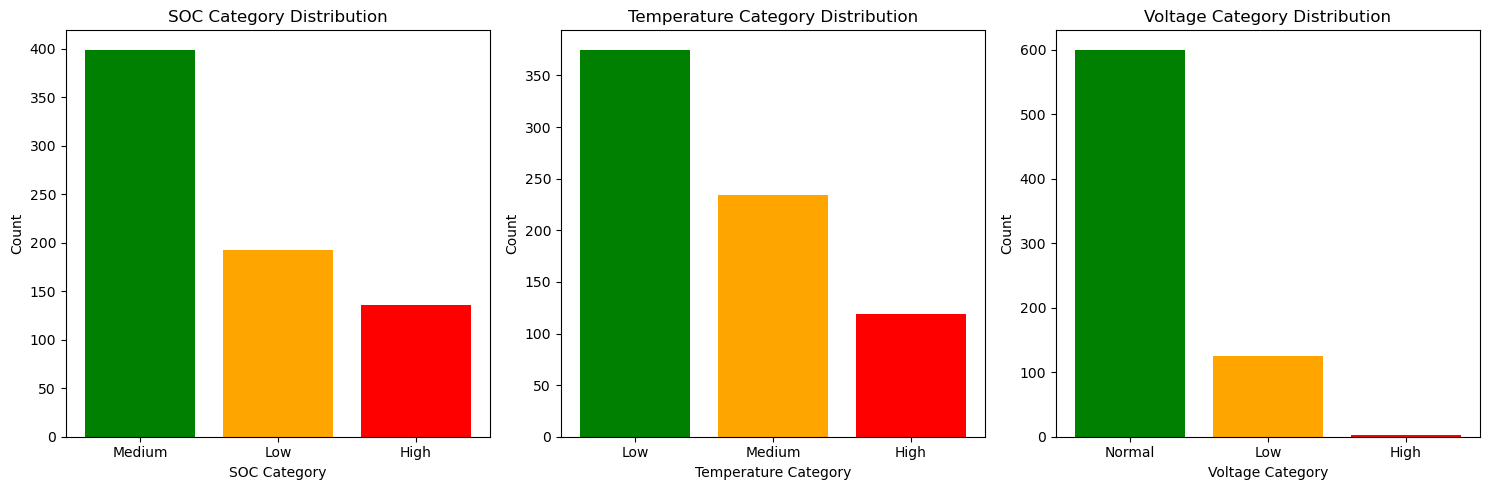

In [34]:
# Create subplots for SOC, Temperature, and Voltage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for SOC categories
soc_counts = data['SOC_Category'].value_counts()
axes[0].bar(soc_counts.index, soc_counts.values, color=['green', 'orange', 'red'])
axes[0].set_title('SOC Category Distribution')
axes[0].set_xlabel('SOC Category')
axes[0].set_ylabel('Count')

# Plot for Temperature categories
temp_counts = data['Temperature_Category'].value_counts()
axes[1].bar(temp_counts.index, temp_counts.values, color=['green', 'orange', 'red'])
axes[1].set_title('Temperature Category Distribution')
axes[1].set_xlabel('Temperature Category')
axes[1].set_ylabel('Count')

# Plot for Voltage categories
voltage_counts = data['Voltage_Category'].value_counts()
axes[2].bar(voltage_counts.index, voltage_counts.values, color=['green', 'orange', 'red'])
axes[2].set_title('Voltage Category Distribution')
axes[2].set_xlabel('Voltage Category')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

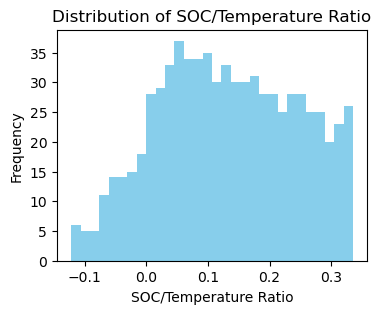

In [35]:
plt.figure(figsize=(4,3))
plt.hist(data['SOC_Temp_Ratio'].dropna(), bins=30, color='skyblue')
plt.title('Distribution of SOC/Temperature Ratio')
plt.xlabel('SOC/Temperature Ratio')
plt.ylabel('Frequency')
plt.show()

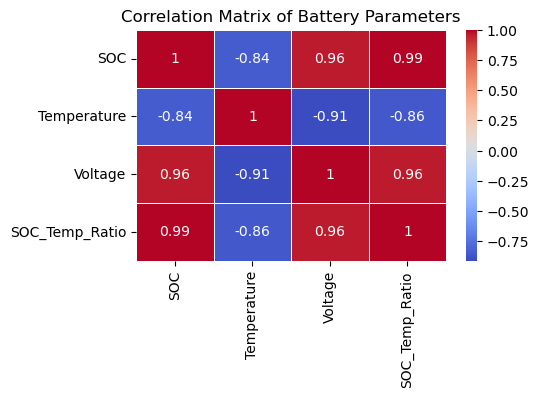

In [36]:
# Select relevant columns for correlation
correlation_data = data[['SOC', 'Temperature', 'Voltage', 'SOC_Temp_Ratio']]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Battery Parameters')
plt.show()

## STATISTICAL ANALYSIS

In [37]:
data.describe()

,SOC,Temperature,Voltage,Label,SOC_Temp_Ratio
count,728.000000,728.000000,728.000000,728.000000,728.000000
mean,43.502258,357.340846,3.342955,0.500000,0.132897
std,35.594267,41.813497,0.347301,0.500344,0.111466
min,-51.021069,298.150000,2.642465,0.000000,-0.121981
25%,18.167601,324.526835,3.120409,0.000000,0.047814
50%,45.863891,348.360233,3.384624,0.500000,0.129209
75%,73.111159,386.258504,3.615127,1.000000,0.223813
max,100.000000,488.862038,4.019340,1.000000,0.335402


In [38]:
from scipy import stats

# Perform ANOVA for SOC vs Label
f_val, p_val = stats.f_oneway(data[data['Label'] == 0]['SOC'],
                              data[data['Label'] == 1]['SOC'])
print(f"ANOVA for SOC vs Label: F-value = {f_val}, P-value = {p_val}")

ANOVA for SOC vs Label: F-value = 62.20470848326953, P-value = 1.1377669087801805e-14


In [39]:
# Perform ANOVA for Temperature vs Label
f_val, p_val = stats.f_oneway(data[data['Label'] == 0]['Temperature'],
                              data[data['Label'] == 1]['Temperature'])
print(f"ANOVA for Temperature vs Label: F-value = {f_val}, P-value = {p_val}")

ANOVA for Temperature vs Label: F-value = 139.76817242720213, P-value = 1.2807963062474793e-29


In [40]:
# Perform ANOVA for Voltage vs Label
f_val, p_val = stats.f_oneway(data[data['Label'] == 0]['Voltage'],
                              data[data['Label'] == 1]['Voltage'])
print(f"ANOVA for Voltage vs Label: F-value = {f_val}, P-value = {p_val}")

ANOVA for Voltage vs Label: F-value = 132.01209581045794, P-value = 3.4389527779177096e-28


In [41]:
from scipy.stats import chi2_contingency

# Create a contingency table for SOC_Category and Label
soc_contingency = pd.crosstab(data['SOC_Category'], data['Label'])
chi2, p, dof, ex = chi2_contingency(soc_contingency)
print(f"Chi-Square for SOC_Category vs Label: Chi2 = {chi2}, P-value = {p}")

# Create a contingency table for Temperature_Category and Label
temp_contingency = pd.crosstab(data['Temperature_Category'], data['Label'])
chi2, p, dof, ex = chi2_contingency(temp_contingency)
print(f"Chi-Square for Temperature_Category vs Label: Chi2 = {chi2}, P-value = {p}")

# Create a contingency table for Voltage_Category and Label
volt_contingency = pd.crosstab(data['Voltage_Category'], data['Label'])
chi2, p, dof, ex = chi2_contingency(volt_contingency)
print(f"Chi-Square for Voltage_Category vs Label: Chi2 = {chi2}, P-value = {p}")

Chi-Square for SOC_Category vs Label: Chi2 = 58.39789010777478, P-value = 2.0847754571424326e-13
Chi-Square for Temperature_Category vs Label: Chi2 = 103.51795676219204, P-value = 3.3217068350618304e-23
Chi-Square for Voltage_Category vs Label: Chi2 = 102.54533333333335, P-value = 5.402114614509678e-23


In [42]:
# Perform T-test/ANOVA for SOC/Temperature Ratio vs Label
f_val, p_val = stats.f_oneway(
    data[data['Label'] == 0]['SOC_Temp_Ratio'],
    data[data['Label'] == 1]['SOC_Temp_Ratio']
)

print(f"ANOVA for SOC/Temperature Ratio vs Label: F-value = {f_val}, P-value = {p_val}")

ANOVA for SOC/Temperature Ratio vs Label: F-value = 60.74907421970311, P-value = 2.2493118538564933e-14


## MODEL BUILDING

#### TRAIN-TEST SPLIT

In [54]:
from sklearn.model_selection import train_test_split

# Define your feature set (X) and target variable (y)
X = data[['SOC', 'Temperature', 'Voltage', 'SOC_Temp_Ratio']]  # Use relevant features
y = data['Label']  # Target variable (Healthy/Unhealthy battery)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### LOGISTIC REGRESSION

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create a Logistic Regression model
model = LogisticRegression(max_iter=500)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.684931506849315
              precision    recall  f1-score   support

           0       0.76      0.63      0.69        81
           1       0.62      0.75      0.68        65

    accuracy                           0.68       146
   macro avg       0.69      0.69      0.68       146
weighted avg       0.70      0.68      0.69       146



#### RANDOM FOREST 

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model = RandomForestClassifier()

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.863013698630137
              precision    recall  f1-score   support

           0       0.96      0.79      0.86        81
           1       0.78      0.95      0.86        65

    accuracy                           0.86       146
   macro avg       0.87      0.87      0.86       146
weighted avg       0.88      0.86      0.86       146



#### FEATURE IMPORTANCE

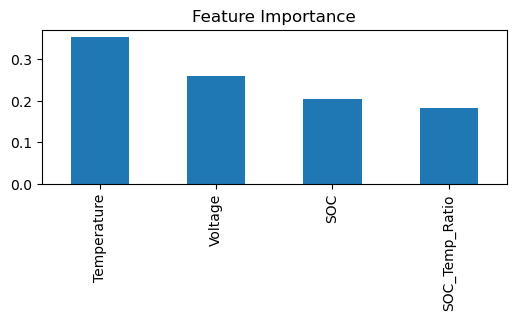

In [57]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(6, 2))
plt.title('Feature Importance')
plt.show()

## MODEL EVALUATION

<Figure size 500x300 with 0 Axes>

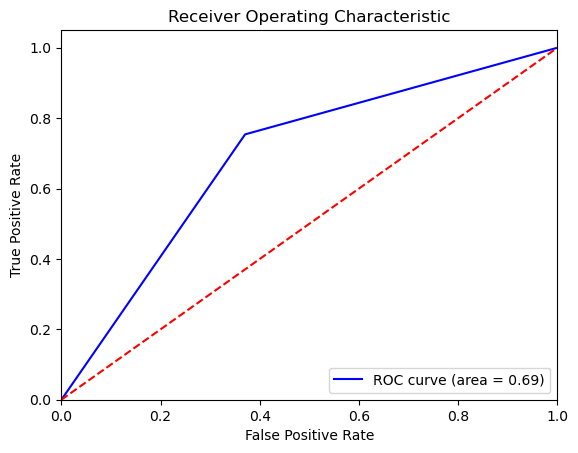

In [74]:
from sklearn.metrics import roc_curve, auc

# For Logistic Regression
plt.figure(figsize=(5, 3))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [64]:
# Get predicted probabilities for the positive class (1)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

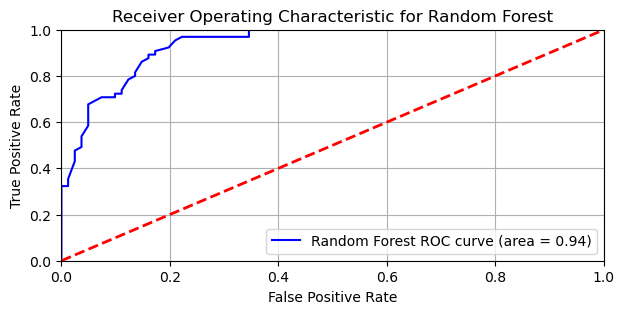

In [66]:
plt.figure(figsize=(7, 3))
plt.plot(fpr_rf, tpr_rf, color='blue', label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [69]:
from sklearn.metrics import classification_report, roc_auc_score

# Get the classification report for both models
logistic_report = classification_report(y_test, y_pred, output_dict=True)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Create a DataFrame to hold the metrics
metrics = {
    'Metric': ['Accuracy', 'Precision (0)', 'Recall (0)', 'F1-Score (0)', 
               'Precision (1)', 'Recall (1)', 'F1-Score (1)', 
               'ROC AUC'],
    'Logistic Regression': [
        accuracy, 
        logistic_report['0']['precision'],
        logistic_report['0']['recall'],
        logistic_report['0']['f1-score'],
        logistic_report['1']['precision'],
        logistic_report['1']['recall'],
        logistic_report['1']['f1-score'],
        roc_auc
    ],
    'Random Forest': [
        accuracy_rf, 
        rf_report['0']['precision'],
        rf_report['0']['recall'],
        rf_report['0']['f1-score'],
        rf_report['1']['precision'],
        rf_report['1']['recall'],
        rf_report['1']['f1-score'],
        roc_auc_rf
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Logistic Regression,Random Forest
0,Accuracy,0.684932,0.863014
1,Precision (0),0.761194,0.955224
2,Recall (0),0.629630,0.790123
3,F1-Score (0),0.689189,0.864865
4,Precision (1),0.620253,0.784810
5,Recall (1),0.753846,0.953846
6,F1-Score (1),0.680556,0.861111
7,ROC AUC,0.691738,0.936562


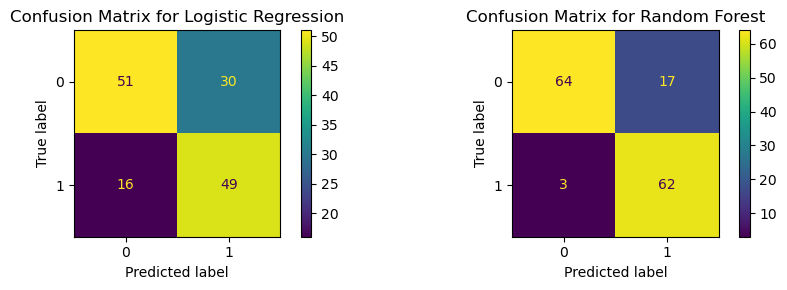

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# Confusion Matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic)
disp_logistic.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix for Logistic Regression')

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix for Random Forest')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [71]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(model, X, y, cv=5)
print(f'Cross-validation scores for Logistic Regression: {cv_scores_logistic}')
print(f'Mean cross-validation score for Logistic Regression: {cv_scores_logistic.mean()}')

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5)
print(f'Cross-validation scores for Random Forest: {cv_scores_rf}')
print(f'Mean cross-validation score for Random Forest: {cv_scores_rf.mean()}')

Cross-validation scores for Logistic Regression: [0.70547945 0.67808219 0.69178082 0.5862069  0.57931034]
Mean cross-validation score for Logistic Regression: 0.648171941426547
Cross-validation scores for Random Forest: [0.71917808 0.66438356 0.78767123 0.82758621 0.56551724]
Mean cross-validation score for Random Forest: 0.7128672649976382


## MODEL OPTIMIZATION

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [59]:
# Use the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Create the Random Forest model with the best parameters
optimized_rf_model = RandomForestClassifier(**best_params)

# Train the optimized model
optimized_rf_model.fit(X_train, y_train)

# Predict on the test set using the optimized model
y_pred_optimized = optimized_rf_model.predict(X_test)

# Evaluate the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f'Optimized Random Forest Accuracy: {accuracy_optimized}')
print(classification_report(y_test, y_pred_optimized))

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest Accuracy: 0.863013698630137
              precision    recall  f1-score   support

           0       0.94      0.80      0.87        81
           1       0.79      0.94      0.86        65

    accuracy                           0.86       146
   macro avg       0.87      0.87      0.86       146
weighted avg       0.88      0.86      0.86       146

